# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.90

"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 1000
SCHEDULER_PARIENCE = 10
COOLDOWN = 50

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 70
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"

if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'MyResNet32_128_SGD_90'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  45000
- Length of Valid Set :  5000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if valid_data is not None:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
else:
    valid_dataloader = None

if test_data is not None:
    test_dataloader = DataLoader(
        test_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("test.transforms =", test_data.transform, test_dataloader.batch_size)
else:
    test_dataloader = None

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
valid.transforms = ToTensor() 128
test.transforms = ToTensor() 128


## Confirm that the dataset is loaded properly

Shape of X [N, C, H, W]: torch.Size([128, 3, 32, 32])
mean of X tensor([0.5023, 0.4960, 0.4644])
Shape of y: torch.Size([128]) torch.int64


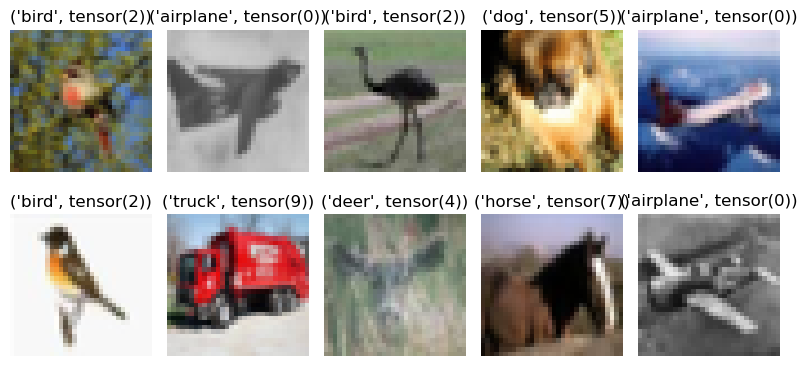

In [6]:
if test_data is not None:
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis("off")
            count += 1

            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

## Model Confirm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(
        num_classes=COUNT_OF_CLASSES, 
        Downsample_option="A"
    ).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")


ResNet-32 for CIFAR10 is loaded.


In [9]:
# model.named_modules

In [10]:
# tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
# flops = FlopCountAnalysis(model, tmp_input)
# print(flop_count_table(flops))

# Define Training

## (1) Define Criterion

In [11]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [12]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## (3) Define Early Stopping

In [13]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_path=file_path)

## (4) Define Learning Rate schedualer

In [14]:
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=SCHEDULER_PARIENCE,
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    cooldown=COOLDOWN,
)

# scheduler = MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)
"""
=======================================================
if batch = 256
=======================================================
non-split [single epoch = 196 iter] : milestones = [164, 246]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
if batch = 128
=======================================================
non-split [signle epoch = 391 iter]: milestones = [82, 123]
- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1
- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01
- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [signle epoch = 352 iter]: milestones = [91, 137]
- 1~91 epochs == 1 ~ 32k iter >> lr = 0.1
- 92~137 epochs == 32k ~ 48k iter >> lr = 0.01
- 138~(183) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

'\n=======================================================\nif batch = 256\n=======================================================\nnon-split [single epoch = 196 iter] : milestones = [164, 246]\n- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1\n- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01\n- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nsplit to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]\n- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1\n- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01\n- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nif batch = 128\n=======================================================\nnon-split [signle epoch = 391 iter]: milestones = [82, 123]\n- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1\n- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01\n- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001\n=================================================

## (5) Define AMP scaler

In [15]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [16]:
if os.path.exists(file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [17]:
optimizer.param_groups[0]["lr"]

0.1

# [Training Loop]

In [18]:
if valid_data is None:
    valid_dataloader = None
if test_data is None:
    test_dataloader = None

In [19]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/1000] :


train: 100%|██████████| 352/352 [00:19<00:00, 18.09it/s]

Train Loss: 0.0064 | Train Acc: 15.28%


Valid Loss: 2.1886 | Valid Acc: 17.84%
Test  Loss: 3.2908 | Test Acc: 18.33%
updated best eval loss : 2.1885907739400863
--------------------------------------------------
[Epoch 2/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.91it/s]


Train Loss: 0.0060 | Train Acc: 16.67%
Valid Loss: 2.0598 | Valid Acc: 25.10%
Test  Loss: 2.1653 | Test Acc: 26.88%
updated best eval loss : 2.0598230212926865
--------------------------------------------------
[Epoch 3/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.59it/s]


Train Loss: 0.0044 | Train Acc: 44.44%
Valid Loss: 1.6394 | Valid Acc: 41.36%
Test  Loss: 1.6676 | Test Acc: 40.90%
updated best eval loss : 1.6393632382154464
--------------------------------------------------
[Epoch 4/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.83it/s]


Train Loss: 0.0042 | Train Acc: 47.22%
Valid Loss: 1.5014 | Valid Acc: 48.08%
Test  Loss: 2.0515 | Test Acc: 38.16%
updated best eval loss : 1.5013961255550385
--------------------------------------------------
[Epoch 5/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.51it/s]


Train Loss: 0.0040 | Train Acc: 51.39%
Valid Loss: 1.4702 | Valid Acc: 51.48%
Test  Loss: 1.6913 | Test Acc: 45.82%
updated best eval loss : 1.4701738208532333
--------------------------------------------------
[Epoch 6/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.15it/s]


Train Loss: 0.0028 | Train Acc: 62.50%
Valid Loss: 1.1200 | Valid Acc: 59.88%
Test  Loss: 1.0955 | Test Acc: 62.46%
updated best eval loss : 1.1199916757643222
--------------------------------------------------
[Epoch 7/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.23it/s]


Train Loss: 0.0030 | Train Acc: 63.89%
Valid Loss: 1.2540 | Valid Acc: 57.86%
Test  Loss: 1.1133 | Test Acc: 62.48%
--------------------------------------------------
[Epoch 8/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.84it/s]


Train Loss: 0.0026 | Train Acc: 65.28%
Valid Loss: 0.9119 | Valid Acc: 68.00%
Test  Loss: 0.8371 | Test Acc: 70.88%
updated best eval loss : 0.9118533104658126
--------------------------------------------------
[Epoch 9/1000] :


train: 100%|██████████| 352/352 [00:14<00:00, 23.53it/s]


Train Loss: 0.0018 | Train Acc: 77.78%
Valid Loss: 0.9364 | Valid Acc: 67.94%
Test  Loss: 1.0210 | Test Acc: 66.99%
--------------------------------------------------
[Epoch 10/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.29it/s]


Train Loss: 0.0019 | Train Acc: 72.22%
Valid Loss: 0.9171 | Valid Acc: 68.80%
Test  Loss: 1.0242 | Test Acc: 65.71%
--------------------------------------------------
[Epoch 11/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.83it/s]


Train Loss: 0.0022 | Train Acc: 72.22%
Valid Loss: 0.8293 | Valid Acc: 71.42%
Test  Loss: 0.7890 | Test Acc: 72.49%
updated best eval loss : 0.8292955830693245
--------------------------------------------------
[Epoch 12/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.78it/s]


Train Loss: 0.0022 | Train Acc: 69.44%
Valid Loss: 0.9572 | Valid Acc: 68.10%
Test  Loss: 1.4320 | Test Acc: 60.67%
--------------------------------------------------
[Epoch 13/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.68it/s]


Train Loss: 0.0023 | Train Acc: 75.00%
Valid Loss: 0.8322 | Valid Acc: 71.34%
Test  Loss: 0.8556 | Test Acc: 72.32%
--------------------------------------------------
[Epoch 14/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.66it/s]


Train Loss: 0.0016 | Train Acc: 80.56%
Valid Loss: 0.7644 | Valid Acc: 73.70%
Test  Loss: 0.7118 | Test Acc: 75.95%
updated best eval loss : 0.7644101426005363
--------------------------------------------------
[Epoch 15/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.46it/s]


Train Loss: 0.0024 | Train Acc: 72.22%
Valid Loss: 0.7634 | Valid Acc: 74.04%
Test  Loss: 0.8964 | Test Acc: 71.60%
updated best eval loss : 0.763377208262682
--------------------------------------------------
[Epoch 16/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.33it/s]


Train Loss: 0.0026 | Train Acc: 72.22%
Valid Loss: 0.7398 | Valid Acc: 74.96%
Test  Loss: 0.6359 | Test Acc: 78.50%
updated best eval loss : 0.7397607952356339
--------------------------------------------------
[Epoch 17/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.74it/s]


Train Loss: 0.0024 | Train Acc: 70.83%
Valid Loss: 0.7142 | Valid Acc: 74.82%
Test  Loss: 0.6143 | Test Acc: 78.82%
updated best eval loss : 0.7142051160335541
--------------------------------------------------
[Epoch 18/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.78it/s]


Train Loss: 0.0008 | Train Acc: 93.06%
Valid Loss: 0.6846 | Valid Acc: 75.94%
Test  Loss: 0.7677 | Test Acc: 73.79%
updated best eval loss : 0.6845679797232151
--------------------------------------------------
[Epoch 19/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.25it/s]


Train Loss: 0.0021 | Train Acc: 75.00%
Valid Loss: 0.6750 | Valid Acc: 76.46%
Test  Loss: 0.7568 | Test Acc: 74.86%
updated best eval loss : 0.6749539352953434
--------------------------------------------------
[Epoch 20/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.12it/s]


Train Loss: 0.0018 | Train Acc: 81.94%
Valid Loss: 0.7774 | Valid Acc: 73.84%
Test  Loss: 0.7296 | Test Acc: 75.31%
--------------------------------------------------
[Epoch 21/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.99it/s]


Train Loss: 0.0021 | Train Acc: 73.61%
Valid Loss: 0.8157 | Valid Acc: 72.98%
Test  Loss: 0.7817 | Test Acc: 75.56%
--------------------------------------------------
[Epoch 22/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.58it/s]


Train Loss: 0.0021 | Train Acc: 75.00%
Valid Loss: 0.7433 | Valid Acc: 74.50%
Test  Loss: 0.7372 | Test Acc: 75.55%
--------------------------------------------------
[Epoch 23/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.19it/s]


Train Loss: 0.0012 | Train Acc: 84.72%
Valid Loss: 0.8823 | Valid Acc: 72.60%
Test  Loss: 0.9640 | Test Acc: 71.01%
--------------------------------------------------
[Epoch 24/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.58it/s]


Train Loss: 0.0018 | Train Acc: 81.94%
Valid Loss: 0.8359 | Valid Acc: 72.86%
Test  Loss: 0.9722 | Test Acc: 68.78%
--------------------------------------------------
[Epoch 25/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.36it/s]


Train Loss: 0.0011 | Train Acc: 88.89%
Valid Loss: 0.6675 | Valid Acc: 77.12%
Test  Loss: 0.6172 | Test Acc: 79.25%
updated best eval loss : 0.6674546241760254
--------------------------------------------------
[Epoch 26/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.76it/s]


Train Loss: 0.0022 | Train Acc: 77.78%
Valid Loss: 0.6625 | Valid Acc: 76.54%
Test  Loss: 0.8861 | Test Acc: 70.88%
updated best eval loss : 0.6624764010310173
--------------------------------------------------
[Epoch 27/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.70it/s]


Train Loss: 0.0014 | Train Acc: 79.17%
Valid Loss: 0.7361 | Valid Acc: 74.88%
Test  Loss: 0.7018 | Test Acc: 77.35%
--------------------------------------------------
[Epoch 28/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.70it/s]


Train Loss: 0.0013 | Train Acc: 84.72%
Valid Loss: 0.6058 | Valid Acc: 79.82%
Test  Loss: 0.4912 | Test Acc: 83.26%
updated best eval loss : 0.605836120992899
--------------------------------------------------
[Epoch 29/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.38it/s]


Train Loss: 0.0015 | Train Acc: 79.17%
Valid Loss: 0.6374 | Valid Acc: 78.34%
Test  Loss: 0.6388 | Test Acc: 78.26%
--------------------------------------------------
[Epoch 30/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.46it/s]


Train Loss: 0.0019 | Train Acc: 77.78%
Valid Loss: 0.6531 | Valid Acc: 77.22%
Test  Loss: 0.6029 | Test Acc: 79.23%
--------------------------------------------------
[Epoch 31/1000] :


train: 100%|██████████| 352/352 [00:14<00:00, 23.55it/s]


Train Loss: 0.0011 | Train Acc: 88.89%
Valid Loss: 0.7159 | Valid Acc: 75.64%
Test  Loss: 0.6755 | Test Acc: 77.55%
--------------------------------------------------
[Epoch 32/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.00it/s]


Train Loss: 0.0012 | Train Acc: 86.11%
Valid Loss: 0.6597 | Valid Acc: 78.04%
Test  Loss: 0.6118 | Test Acc: 78.99%
--------------------------------------------------
[Epoch 33/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.56it/s]


Train Loss: 0.0009 | Train Acc: 84.72%
Valid Loss: 0.6472 | Valid Acc: 77.54%
Test  Loss: 0.6475 | Test Acc: 77.63%
--------------------------------------------------
[Epoch 34/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.10it/s]


Train Loss: 0.0023 | Train Acc: 69.44%
Valid Loss: 0.7195 | Valid Acc: 75.66%
Test  Loss: 0.7783 | Test Acc: 74.75%
--------------------------------------------------
[Epoch 35/1000] :


train: 100%|██████████| 352/352 [00:14<00:00, 23.57it/s]


Train Loss: 0.0013 | Train Acc: 87.50%
Valid Loss: 0.6356 | Valid Acc: 78.82%
Test  Loss: 0.5575 | Test Acc: 81.03%
--------------------------------------------------
[Epoch 36/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.96it/s]


Train Loss: 0.0015 | Train Acc: 81.94%
Valid Loss: 0.6793 | Valid Acc: 76.46%
Test  Loss: 0.6206 | Test Acc: 78.79%
--------------------------------------------------
[Epoch 37/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.06it/s]


Train Loss: 0.0012 | Train Acc: 87.50%
Valid Loss: 0.6375 | Valid Acc: 77.88%
Test  Loss: 0.6481 | Test Acc: 78.33%
--------------------------------------------------
[Epoch 38/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.07it/s]


Train Loss: 0.0020 | Train Acc: 76.39%
Valid Loss: 0.5817 | Valid Acc: 78.68%
Test  Loss: 0.6025 | Test Acc: 79.33%
updated best eval loss : 0.5817422404885292
--------------------------------------------------
[Epoch 39/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.21it/s]


Train Loss: 0.0011 | Train Acc: 88.89%
Valid Loss: 0.6337 | Valid Acc: 77.62%
Test  Loss: 0.6856 | Test Acc: 77.05%
--------------------------------------------------
[Epoch 40/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.77it/s]


Train Loss: 0.0009 | Train Acc: 87.50%
Valid Loss: 0.6573 | Valid Acc: 77.06%
Test  Loss: 0.5829 | Test Acc: 80.53%
--------------------------------------------------
[Epoch 41/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.45it/s]


Train Loss: 0.0008 | Train Acc: 90.28%
Valid Loss: 0.6343 | Valid Acc: 77.96%
Test  Loss: 0.5850 | Test Acc: 79.68%
--------------------------------------------------
[Epoch 42/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.29it/s]


Train Loss: 0.0015 | Train Acc: 86.11%
Valid Loss: 0.6020 | Valid Acc: 79.00%
Test  Loss: 0.6326 | Test Acc: 78.97%
--------------------------------------------------
[Epoch 43/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.03it/s]


Train Loss: 0.0011 | Train Acc: 83.33%
Valid Loss: 0.6379 | Valid Acc: 78.36%
Test  Loss: 0.5656 | Test Acc: 80.76%
--------------------------------------------------
[Epoch 44/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.63it/s]


Train Loss: 0.0016 | Train Acc: 79.17%
Valid Loss: 0.6666 | Valid Acc: 77.34%
Test  Loss: 0.5910 | Test Acc: 80.45%
--------------------------------------------------
[Epoch 45/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.61it/s]


Train Loss: 0.0020 | Train Acc: 77.78%
Valid Loss: 0.6198 | Valid Acc: 78.48%
Test  Loss: 0.5607 | Test Acc: 80.98%
--------------------------------------------------
[Epoch 46/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.86it/s]


Train Loss: 0.0008 | Train Acc: 94.44%
Valid Loss: 0.7606 | Valid Acc: 75.18%
Test  Loss: 0.6550 | Test Acc: 79.26%
--------------------------------------------------
[Epoch 47/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.19it/s]


Train Loss: 0.0011 | Train Acc: 86.11%
Valid Loss: 0.6152 | Valid Acc: 78.92%
Test  Loss: 0.5409 | Test Acc: 82.06%
--------------------------------------------------
[Epoch 48/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.75it/s]


Train Loss: 0.0010 | Train Acc: 83.33%
Valid Loss: 0.6982 | Valid Acc: 78.04%
Test  Loss: 0.6150 | Test Acc: 79.24%
--------------------------------------------------
[Epoch 49/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.69it/s]


Train Loss: 0.0016 | Train Acc: 80.56%
Valid Loss: 0.6249 | Valid Acc: 78.34%
Test  Loss: 0.6463 | Test Acc: 78.86%
Epoch 00049: reducing learning rate of group 0 to 1.0000e-02.
--------------------------------------------------
[Epoch 50/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.44it/s]


Train Loss: 0.0011 | Train Acc: 90.28%
Valid Loss: 0.4413 | Valid Acc: 84.72%
Test  Loss: 0.4608 | Test Acc: 84.43%
updated best eval loss : 0.44128103405237196
--------------------------------------------------
[Epoch 51/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.87it/s]


Train Loss: 0.0008 | Train Acc: 93.06%
Valid Loss: 0.4491 | Valid Acc: 84.34%
Test  Loss: 0.4628 | Test Acc: 84.57%
--------------------------------------------------
[Epoch 52/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.87it/s]


Train Loss: 0.0011 | Train Acc: 84.72%
Valid Loss: 0.4415 | Valid Acc: 84.56%
Test  Loss: 0.4665 | Test Acc: 84.69%
--------------------------------------------------
[Epoch 53/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.01it/s]


Train Loss: 0.0010 | Train Acc: 88.89%
Valid Loss: 0.4266 | Valid Acc: 85.42%
Test  Loss: 0.4691 | Test Acc: 84.78%
updated best eval loss : 0.42661866154521705
--------------------------------------------------
[Epoch 54/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.95it/s]


Train Loss: 0.0007 | Train Acc: 93.06%
Valid Loss: 0.4498 | Valid Acc: 85.06%
Test  Loss: 0.4727 | Test Acc: 84.32%
--------------------------------------------------
[Epoch 55/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.77it/s]


Train Loss: 0.0009 | Train Acc: 88.89%
Valid Loss: 0.4417 | Valid Acc: 84.78%
Test  Loss: 0.4571 | Test Acc: 84.72%
--------------------------------------------------
[Epoch 56/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.42it/s]


Train Loss: 0.0008 | Train Acc: 90.28%
Valid Loss: 0.4372 | Valid Acc: 85.64%
Test  Loss: 0.4574 | Test Acc: 84.96%
--------------------------------------------------
[Epoch 57/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.69it/s]


Train Loss: 0.0010 | Train Acc: 84.72%
Valid Loss: 0.4307 | Valid Acc: 85.40%
Test  Loss: 0.4605 | Test Acc: 84.79%
--------------------------------------------------
[Epoch 58/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.86it/s]


Train Loss: 0.0009 | Train Acc: 88.89%
Valid Loss: 0.3872 | Valid Acc: 86.40%
Test  Loss: 0.4385 | Test Acc: 85.68%
updated best eval loss : 0.38717220835387706
--------------------------------------------------
[Epoch 59/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.55it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.4155 | Valid Acc: 85.80%
Test  Loss: 0.4463 | Test Acc: 85.24%
--------------------------------------------------
[Epoch 60/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.83it/s]


Train Loss: 0.0006 | Train Acc: 90.28%
Valid Loss: 0.4035 | Valid Acc: 85.74%
Test  Loss: 0.4460 | Test Acc: 85.54%
--------------------------------------------------
[Epoch 61/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.46it/s]


Train Loss: 0.0011 | Train Acc: 87.50%
Valid Loss: 0.4449 | Valid Acc: 84.98%
Test  Loss: 0.4653 | Test Acc: 84.77%
--------------------------------------------------
[Epoch 62/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.17it/s]


Train Loss: 0.0014 | Train Acc: 83.33%
Valid Loss: 0.3972 | Valid Acc: 86.44%
Test  Loss: 0.5156 | Test Acc: 83.28%
--------------------------------------------------
[Epoch 63/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.69it/s]


Train Loss: 0.0011 | Train Acc: 90.28%
Valid Loss: 0.4141 | Valid Acc: 85.94%
Test  Loss: 0.4439 | Test Acc: 85.52%
--------------------------------------------------
[Epoch 64/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.43it/s]


Train Loss: 0.0007 | Train Acc: 90.28%
Valid Loss: 0.4255 | Valid Acc: 86.02%
Test  Loss: 0.4939 | Test Acc: 83.78%
--------------------------------------------------
[Epoch 65/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.62it/s]


Train Loss: 0.0010 | Train Acc: 86.11%
Valid Loss: 0.4041 | Valid Acc: 86.26%
Test  Loss: 0.4886 | Test Acc: 84.13%
--------------------------------------------------
[Epoch 66/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.66it/s]


Train Loss: 0.0008 | Train Acc: 90.28%
Valid Loss: 0.4438 | Valid Acc: 85.28%
Test  Loss: 0.4902 | Test Acc: 84.50%
--------------------------------------------------
[Epoch 67/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.46it/s]


Train Loss: 0.0005 | Train Acc: 93.06%
Valid Loss: 0.4210 | Valid Acc: 85.86%
Test  Loss: 0.4885 | Test Acc: 83.96%
--------------------------------------------------
[Epoch 68/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.62it/s]


Train Loss: 0.0009 | Train Acc: 86.11%
Valid Loss: 0.4021 | Valid Acc: 86.24%
Test  Loss: 0.5040 | Test Acc: 84.00%
--------------------------------------------------
[Epoch 69/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.96it/s]


Train Loss: 0.0006 | Train Acc: 88.89%
Valid Loss: 0.4195 | Valid Acc: 86.20%
Test  Loss: 0.5197 | Test Acc: 83.63%
--------------------------------------------------
[Epoch 70/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.07it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.4214 | Valid Acc: 85.96%
Test  Loss: 0.5043 | Test Acc: 83.85%
--------------------------------------------------
[Epoch 71/1000] :


train: 100%|██████████| 352/352 [00:14<00:00, 23.67it/s]


Train Loss: 0.0012 | Train Acc: 86.11%
Valid Loss: 0.4110 | Valid Acc: 86.06%
Test  Loss: 0.5396 | Test Acc: 82.70%
--------------------------------------------------
[Epoch 72/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.31it/s]


Train Loss: 0.0009 | Train Acc: 88.89%
Valid Loss: 0.3951 | Valid Acc: 86.38%
Test  Loss: 0.5035 | Test Acc: 83.81%
--------------------------------------------------
[Epoch 73/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.83it/s]


Train Loss: 0.0014 | Train Acc: 87.50%
Valid Loss: 0.4024 | Valid Acc: 86.30%
Test  Loss: 0.5260 | Test Acc: 83.09%
--------------------------------------------------
[Epoch 74/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.52it/s]


Train Loss: 0.0011 | Train Acc: 86.11%
Valid Loss: 0.4057 | Valid Acc: 86.82%
Test  Loss: 0.4794 | Test Acc: 84.51%
--------------------------------------------------
[Epoch 75/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.88it/s]


Train Loss: 0.0007 | Train Acc: 88.89%
Valid Loss: 0.4185 | Valid Acc: 85.80%
Test  Loss: 0.5268 | Test Acc: 83.67%
--------------------------------------------------
[Epoch 76/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.28it/s]


Train Loss: 0.0006 | Train Acc: 95.83%
Valid Loss: 0.4181 | Valid Acc: 85.40%
Test  Loss: 0.5031 | Test Acc: 84.00%
--------------------------------------------------
[Epoch 77/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.95it/s]


Train Loss: 0.0005 | Train Acc: 90.28%
Valid Loss: 0.4166 | Valid Acc: 86.42%
Test  Loss: 0.5245 | Test Acc: 83.16%
--------------------------------------------------
[Epoch 78/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.56it/s]


Train Loss: 0.0012 | Train Acc: 88.89%
Valid Loss: 0.4065 | Valid Acc: 86.42%
Test  Loss: 0.5156 | Test Acc: 83.61%
--------------------------------------------------
[Epoch 79/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.95it/s]


Train Loss: 0.0008 | Train Acc: 88.89%
Valid Loss: 0.4132 | Valid Acc: 85.68%
Test  Loss: 0.4917 | Test Acc: 84.53%
--------------------------------------------------
[Epoch 80/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.63it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.4064 | Valid Acc: 86.10%
Test  Loss: 0.5041 | Test Acc: 84.22%
--------------------------------------------------
[Epoch 81/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.68it/s]


Train Loss: 0.0009 | Train Acc: 90.28%
Valid Loss: 0.4131 | Valid Acc: 85.72%
Test  Loss: 0.5280 | Test Acc: 83.07%
--------------------------------------------------
[Epoch 82/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.49it/s]


Train Loss: 0.0006 | Train Acc: 93.06%
Valid Loss: 0.4001 | Valid Acc: 86.24%
Test  Loss: 0.5172 | Test Acc: 83.62%
--------------------------------------------------
[Epoch 83/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.16it/s]


Train Loss: 0.0008 | Train Acc: 91.67%
Valid Loss: 0.4145 | Valid Acc: 86.02%
Test  Loss: 0.4595 | Test Acc: 85.54%
--------------------------------------------------
[Epoch 84/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.77it/s]


Train Loss: 0.0007 | Train Acc: 90.28%
Valid Loss: 0.4121 | Valid Acc: 86.52%
Test  Loss: 0.5069 | Test Acc: 84.11%
--------------------------------------------------
[Epoch 85/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.83it/s]


Train Loss: 0.0007 | Train Acc: 90.28%
Valid Loss: 0.4156 | Valid Acc: 86.96%
Test  Loss: 0.5379 | Test Acc: 82.61%
--------------------------------------------------
[Epoch 86/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.11it/s]


Train Loss: 0.0004 | Train Acc: 91.67%
Valid Loss: 0.3953 | Valid Acc: 86.32%
Test  Loss: 0.5688 | Test Acc: 81.89%
--------------------------------------------------
[Epoch 87/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.78it/s]


Train Loss: 0.0008 | Train Acc: 90.28%
Valid Loss: 0.4171 | Valid Acc: 86.04%
Test  Loss: 0.4976 | Test Acc: 84.49%
--------------------------------------------------
[Epoch 88/1000] :


train: 100%|██████████| 352/352 [00:14<00:00, 23.78it/s]


Train Loss: 0.0007 | Train Acc: 90.28%
Valid Loss: 0.4329 | Valid Acc: 86.08%
Test  Loss: 0.4953 | Test Acc: 84.60%
--------------------------------------------------
[Epoch 89/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.16it/s]


Train Loss: 0.0006 | Train Acc: 94.44%
Valid Loss: 0.4159 | Valid Acc: 86.46%
Test  Loss: 0.5297 | Test Acc: 83.72%
--------------------------------------------------
[Epoch 90/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.00it/s]


Train Loss: 0.0006 | Train Acc: 94.44%
Valid Loss: 0.4156 | Valid Acc: 86.12%
Test  Loss: 0.5138 | Test Acc: 83.65%
--------------------------------------------------
[Epoch 91/1000] :


train: 100%|██████████| 352/352 [00:14<00:00, 23.48it/s]


Train Loss: 0.0009 | Train Acc: 88.89%
Valid Loss: 0.4138 | Valid Acc: 86.66%
Test  Loss: 0.5304 | Test Acc: 83.13%
--------------------------------------------------
[Epoch 92/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.89it/s]


Train Loss: 0.0005 | Train Acc: 91.67%
Valid Loss: 0.4120 | Valid Acc: 86.42%
Test  Loss: 0.5244 | Test Acc: 83.76%
--------------------------------------------------
[Epoch 93/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.20it/s]


Train Loss: 0.0005 | Train Acc: 95.83%
Valid Loss: 0.4283 | Valid Acc: 86.26%
Test  Loss: 0.4996 | Test Acc: 84.46%
--------------------------------------------------
[Epoch 94/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.13it/s]


Train Loss: 0.0013 | Train Acc: 81.94%
Valid Loss: 0.4210 | Valid Acc: 86.38%
Test  Loss: 0.5424 | Test Acc: 83.27%
--------------------------------------------------
[Epoch 95/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.28it/s]


Train Loss: 0.0005 | Train Acc: 94.44%
Valid Loss: 0.4084 | Valid Acc: 86.48%
Test  Loss: 0.5480 | Test Acc: 83.06%
--------------------------------------------------
[Epoch 96/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.85it/s]


Train Loss: 0.0011 | Train Acc: 87.50%
Valid Loss: 0.4031 | Valid Acc: 86.68%
Test  Loss: 0.4968 | Test Acc: 84.22%
--------------------------------------------------
[Epoch 97/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.51it/s]


Train Loss: 0.0014 | Train Acc: 81.94%
Valid Loss: 0.4073 | Valid Acc: 85.94%
Test  Loss: 0.5129 | Test Acc: 83.76%
--------------------------------------------------
[Epoch 98/1000] :


train: 100%|██████████| 352/352 [00:14<00:00, 23.75it/s]


Train Loss: 0.0011 | Train Acc: 86.11%
Valid Loss: 0.4062 | Valid Acc: 86.54%
Test  Loss: 0.5333 | Test Acc: 83.67%
--------------------------------------------------
[Epoch 99/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.86it/s]


Train Loss: 0.0003 | Train Acc: 98.61%
Valid Loss: 0.4028 | Valid Acc: 85.90%
Test  Loss: 0.5000 | Test Acc: 84.63%
--------------------------------------------------
[Epoch 100/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.66it/s]


Train Loss: 0.0005 | Train Acc: 94.44%
Valid Loss: 0.3992 | Valid Acc: 86.66%
Test  Loss: 0.5301 | Test Acc: 83.55%
--------------------------------------------------
[Epoch 101/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.93it/s]


Train Loss: 0.0008 | Train Acc: 87.50%
Valid Loss: 0.4216 | Valid Acc: 86.42%
Test  Loss: 0.6191 | Test Acc: 81.21%
--------------------------------------------------
[Epoch 102/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.44it/s]


Train Loss: 0.0003 | Train Acc: 95.83%
Valid Loss: 0.4182 | Valid Acc: 86.48%
Test  Loss: 0.5552 | Test Acc: 83.06%
--------------------------------------------------
[Epoch 103/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.64it/s]


Train Loss: 0.0013 | Train Acc: 84.72%
Valid Loss: 0.4140 | Valid Acc: 86.78%
Test  Loss: 0.5599 | Test Acc: 83.10%
--------------------------------------------------
[Epoch 104/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.74it/s]


Train Loss: 0.0009 | Train Acc: 87.50%
Valid Loss: 0.4130 | Valid Acc: 86.24%
Test  Loss: 0.5457 | Test Acc: 82.87%
--------------------------------------------------
[Epoch 105/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.43it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.4224 | Valid Acc: 86.40%
Test  Loss: 0.6454 | Test Acc: 80.97%
--------------------------------------------------
[Epoch 106/1000] :


train: 100%|██████████| 352/352 [00:14<00:00, 23.80it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.4121 | Valid Acc: 86.58%
Test  Loss: 0.5320 | Test Acc: 83.94%
--------------------------------------------------
[Epoch 107/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.16it/s]


Train Loss: 0.0005 | Train Acc: 91.67%
Valid Loss: 0.4106 | Valid Acc: 86.68%
Test  Loss: 0.5334 | Test Acc: 83.43%
--------------------------------------------------
[Epoch 108/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.34it/s]


Train Loss: 0.0007 | Train Acc: 90.28%
Valid Loss: 0.4158 | Valid Acc: 86.76%
Test  Loss: 0.5073 | Test Acc: 84.17%
--------------------------------------------------
[Epoch 109/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.78it/s]


Train Loss: 0.0007 | Train Acc: 90.28%
Valid Loss: 0.4046 | Valid Acc: 86.82%
Test  Loss: 0.5308 | Test Acc: 83.66%
--------------------------------------------------
[Epoch 110/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.36it/s]


Train Loss: 0.0005 | Train Acc: 95.83%
Valid Loss: 0.4245 | Valid Acc: 86.98%
Test  Loss: 0.5435 | Test Acc: 83.01%
Epoch 00110: reducing learning rate of group 0 to 1.0000e-03.
--------------------------------------------------
[Epoch 111/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.41it/s]


Train Loss: 0.0006 | Train Acc: 93.06%
Valid Loss: 0.3906 | Valid Acc: 86.92%
Test  Loss: 0.5150 | Test Acc: 84.08%
--------------------------------------------------
[Epoch 112/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.17it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.4329 | Valid Acc: 85.92%
Test  Loss: 0.5140 | Test Acc: 83.66%
--------------------------------------------------
[Epoch 113/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.07it/s]


Train Loss: 0.0005 | Train Acc: 88.89%
Valid Loss: 0.3866 | Valid Acc: 86.88%
Test  Loss: 0.5106 | Test Acc: 83.92%
updated best eval loss : 0.3865861186175607
--------------------------------------------------
[Epoch 114/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.95it/s]


Train Loss: 0.0005 | Train Acc: 94.44%
Valid Loss: 0.3889 | Valid Acc: 86.66%
Test  Loss: 0.5203 | Test Acc: 83.90%
--------------------------------------------------
[Epoch 115/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.78it/s]


Train Loss: 0.0005 | Train Acc: 93.06%
Valid Loss: 0.3903 | Valid Acc: 87.54%
Test  Loss: 0.5102 | Test Acc: 84.15%
--------------------------------------------------
[Epoch 116/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.59it/s]


Train Loss: 0.0003 | Train Acc: 95.83%
Valid Loss: 0.3823 | Valid Acc: 87.02%
Test  Loss: 0.4980 | Test Acc: 84.32%
updated best eval loss : 0.38229512855759823
--------------------------------------------------
[Epoch 117/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.77it/s]


Train Loss: 0.0007 | Train Acc: 93.06%
Valid Loss: 0.4014 | Valid Acc: 86.94%
Test  Loss: 0.5109 | Test Acc: 83.99%
--------------------------------------------------
[Epoch 118/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.71it/s]


Train Loss: 0.0007 | Train Acc: 90.28%
Valid Loss: 0.3767 | Valid Acc: 87.52%
Test  Loss: 0.5150 | Test Acc: 83.99%
updated best eval loss : 0.37670427821576596
--------------------------------------------------
[Epoch 119/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.13it/s]


Train Loss: 0.0003 | Train Acc: 95.83%
Valid Loss: 0.4047 | Valid Acc: 87.48%
Test  Loss: 0.5165 | Test Acc: 84.01%
--------------------------------------------------
[Epoch 120/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.27it/s]


Train Loss: 0.0004 | Train Acc: 94.44%
Valid Loss: 0.3897 | Valid Acc: 87.08%
Test  Loss: 0.5041 | Test Acc: 84.25%
--------------------------------------------------
[Epoch 121/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.39it/s]


Train Loss: 0.0009 | Train Acc: 87.50%
Valid Loss: 0.4230 | Valid Acc: 86.82%
Test  Loss: 0.5103 | Test Acc: 84.24%
--------------------------------------------------
[Epoch 122/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.22it/s]


Train Loss: 0.0006 | Train Acc: 94.44%
Valid Loss: 0.4023 | Valid Acc: 86.74%
Test  Loss: 0.5053 | Test Acc: 84.31%
--------------------------------------------------
[Epoch 123/1000] :


train: 100%|██████████| 352/352 [00:16<00:00, 21.52it/s]


Train Loss: 0.0007 | Train Acc: 90.28%
Valid Loss: 0.3876 | Valid Acc: 87.38%
Test  Loss: 0.5188 | Test Acc: 84.08%
--------------------------------------------------
[Epoch 124/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.77it/s]


Train Loss: 0.0009 | Train Acc: 93.06%
Valid Loss: 0.3899 | Valid Acc: 87.50%
Test  Loss: 0.5378 | Test Acc: 83.33%
--------------------------------------------------
[Epoch 125/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.49it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.3978 | Valid Acc: 87.10%
Test  Loss: 0.5164 | Test Acc: 83.99%
--------------------------------------------------
[Epoch 126/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.73it/s]


Train Loss: 0.0008 | Train Acc: 91.67%
Valid Loss: 0.4312 | Valid Acc: 86.24%
Test  Loss: 0.5386 | Test Acc: 83.38%
--------------------------------------------------
[Epoch 127/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.00it/s]


Train Loss: 0.0005 | Train Acc: 94.44%
Valid Loss: 0.3905 | Valid Acc: 87.48%
Test  Loss: 0.5339 | Test Acc: 83.60%
--------------------------------------------------
[Epoch 128/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.45it/s]


Train Loss: 0.0007 | Train Acc: 90.28%
Valid Loss: 0.3881 | Valid Acc: 87.02%
Test  Loss: 0.5178 | Test Acc: 83.97%
--------------------------------------------------
[Epoch 129/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.72it/s]


Train Loss: 0.0005 | Train Acc: 93.06%
Valid Loss: 0.3993 | Valid Acc: 87.20%
Test  Loss: 0.5242 | Test Acc: 83.92%
--------------------------------------------------
[Epoch 130/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.98it/s]


Train Loss: 0.0004 | Train Acc: 95.83%
Valid Loss: 0.3946 | Valid Acc: 87.58%
Test  Loss: 0.5489 | Test Acc: 83.25%
--------------------------------------------------
[Epoch 131/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.11it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.3847 | Valid Acc: 87.24%
Test  Loss: 0.5116 | Test Acc: 84.37%
--------------------------------------------------
[Epoch 132/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.16it/s]


Train Loss: 0.0005 | Train Acc: 91.67%
Valid Loss: 0.3995 | Valid Acc: 86.98%
Test  Loss: 0.5105 | Test Acc: 84.31%
--------------------------------------------------
[Epoch 133/1000] :


train: 100%|██████████| 352/352 [00:14<00:00, 23.47it/s]


Train Loss: 0.0004 | Train Acc: 95.83%
Valid Loss: 0.4013 | Valid Acc: 86.54%
Test  Loss: 0.5085 | Test Acc: 84.62%
--------------------------------------------------
[Epoch 134/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.12it/s]


Train Loss: 0.0005 | Train Acc: 93.06%
Valid Loss: 0.3934 | Valid Acc: 87.64%
Test  Loss: 0.5301 | Test Acc: 83.86%
--------------------------------------------------
[Epoch 135/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.14it/s]


Train Loss: 0.0010 | Train Acc: 86.11%
Valid Loss: 0.3802 | Valid Acc: 86.84%
Test  Loss: 0.5121 | Test Acc: 84.29%
--------------------------------------------------
[Epoch 136/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.99it/s]


Train Loss: 0.0005 | Train Acc: 93.06%
Valid Loss: 0.4066 | Valid Acc: 86.72%
Test  Loss: 0.5361 | Test Acc: 83.81%
--------------------------------------------------
[Epoch 137/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.11it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.3824 | Valid Acc: 87.44%
Test  Loss: 0.5387 | Test Acc: 83.65%
--------------------------------------------------
[Epoch 138/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.19it/s]


Train Loss: 0.0006 | Train Acc: 94.44%
Valid Loss: 0.4013 | Valid Acc: 87.12%
Test  Loss: 0.5213 | Test Acc: 84.01%
--------------------------------------------------
[Epoch 139/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.95it/s]


Train Loss: 0.0009 | Train Acc: 90.28%
Valid Loss: 0.3868 | Valid Acc: 87.40%
Test  Loss: 0.5239 | Test Acc: 84.00%
--------------------------------------------------
[Epoch 140/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.18it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.3841 | Valid Acc: 87.00%
Test  Loss: 0.5243 | Test Acc: 83.69%
--------------------------------------------------
[Epoch 141/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.11it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.4124 | Valid Acc: 87.40%
Test  Loss: 0.5570 | Test Acc: 83.10%
--------------------------------------------------
[Epoch 142/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.06it/s]


Train Loss: 0.0006 | Train Acc: 93.06%
Valid Loss: 0.3906 | Valid Acc: 87.36%
Test  Loss: 0.5471 | Test Acc: 83.26%
--------------------------------------------------
[Epoch 143/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.82it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.3918 | Valid Acc: 86.92%
Test  Loss: 0.5245 | Test Acc: 83.96%
--------------------------------------------------
[Epoch 144/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.74it/s]


Train Loss: 0.0005 | Train Acc: 93.06%
Valid Loss: 0.3958 | Valid Acc: 87.40%
Test  Loss: 0.5332 | Test Acc: 83.83%
--------------------------------------------------
[Epoch 145/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.65it/s]


Train Loss: 0.0007 | Train Acc: 88.89%
Valid Loss: 0.4174 | Valid Acc: 86.94%
Test  Loss: 0.5405 | Test Acc: 83.67%
--------------------------------------------------
[Epoch 146/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.11it/s]


Train Loss: 0.0006 | Train Acc: 94.44%
Valid Loss: 0.4325 | Valid Acc: 86.94%
Test  Loss: 0.5461 | Test Acc: 83.52%
--------------------------------------------------
[Epoch 147/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.07it/s]


Train Loss: 0.0003 | Train Acc: 94.44%
Valid Loss: 0.3999 | Valid Acc: 87.04%
Test  Loss: 0.5529 | Test Acc: 83.45%
--------------------------------------------------
[Epoch 148/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.43it/s]


Train Loss: 0.0008 | Train Acc: 90.28%
Valid Loss: 0.3952 | Valid Acc: 87.64%
Test  Loss: 0.5490 | Test Acc: 83.68%
--------------------------------------------------
[Epoch 149/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.76it/s]


Train Loss: 0.0004 | Train Acc: 94.44%
Valid Loss: 0.4124 | Valid Acc: 87.80%
Test  Loss: 0.5497 | Test Acc: 83.23%
--------------------------------------------------
[Epoch 150/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.92it/s]


Train Loss: 0.0005 | Train Acc: 91.67%
Valid Loss: 0.4011 | Valid Acc: 87.14%
Test  Loss: 0.5396 | Test Acc: 83.75%
--------------------------------------------------
[Epoch 151/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.08it/s]


Train Loss: 0.0007 | Train Acc: 93.06%
Valid Loss: 0.3888 | Valid Acc: 87.56%
Test  Loss: 0.5607 | Test Acc: 83.39%
--------------------------------------------------
[Epoch 152/1000] :


train: 100%|██████████| 352/352 [00:14<00:00, 23.67it/s]


Train Loss: 0.0004 | Train Acc: 94.44%
Valid Loss: 0.4193 | Valid Acc: 86.88%
Test  Loss: 0.5590 | Test Acc: 83.35%
--------------------------------------------------
[Epoch 153/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.03it/s]


Train Loss: 0.0009 | Train Acc: 87.50%
Valid Loss: 0.4024 | Valid Acc: 87.34%
Test  Loss: 0.5518 | Test Acc: 83.45%
--------------------------------------------------
[Epoch 154/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.03it/s]


Train Loss: 0.0006 | Train Acc: 93.06%
Valid Loss: 0.3680 | Valid Acc: 87.48%
Test  Loss: 0.5411 | Test Acc: 83.62%
updated best eval loss : 0.3680455598514527
--------------------------------------------------
[Epoch 155/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.13it/s]


Train Loss: 0.0008 | Train Acc: 91.67%
Valid Loss: 0.3681 | Valid Acc: 87.70%
Test  Loss: 0.5428 | Test Acc: 83.37%
--------------------------------------------------
[Epoch 156/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.05it/s]


Train Loss: 0.0002 | Train Acc: 95.83%
Valid Loss: 0.3858 | Valid Acc: 87.84%
Test  Loss: 0.5603 | Test Acc: 83.08%
--------------------------------------------------
[Epoch 157/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.75it/s]


Train Loss: 0.0009 | Train Acc: 87.50%
Valid Loss: 0.3662 | Valid Acc: 88.06%
Test  Loss: 0.5349 | Test Acc: 83.75%
updated best eval loss : 0.36618683964479715
--------------------------------------------------
[Epoch 158/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.14it/s]


Train Loss: 0.0005 | Train Acc: 95.83%
Valid Loss: 0.3843 | Valid Acc: 87.38%
Test  Loss: 0.5486 | Test Acc: 83.52%
--------------------------------------------------
[Epoch 159/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.11it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.4012 | Valid Acc: 87.26%
Test  Loss: 0.5409 | Test Acc: 83.52%
--------------------------------------------------
[Epoch 160/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.57it/s]


Train Loss: 0.0004 | Train Acc: 95.83%
Valid Loss: 0.4096 | Valid Acc: 87.26%
Test  Loss: 0.5416 | Test Acc: 83.43%
--------------------------------------------------
[Epoch 161/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.95it/s]


Train Loss: 0.0003 | Train Acc: 95.83%
Valid Loss: 0.4033 | Valid Acc: 87.12%
Test  Loss: 0.5357 | Test Acc: 83.76%
--------------------------------------------------
[Epoch 162/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.08it/s]


Train Loss: 0.0004 | Train Acc: 94.44%
Valid Loss: 0.4265 | Valid Acc: 87.16%
Test  Loss: 0.5521 | Test Acc: 83.19%
--------------------------------------------------
[Epoch 163/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.80it/s]


Train Loss: 0.0003 | Train Acc: 98.61%
Valid Loss: 0.4008 | Valid Acc: 87.50%
Test  Loss: 0.5381 | Test Acc: 83.77%
--------------------------------------------------
[Epoch 164/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.78it/s]


Train Loss: 0.0004 | Train Acc: 94.44%
Valid Loss: 0.3975 | Valid Acc: 86.84%
Test  Loss: 0.5498 | Test Acc: 83.45%
--------------------------------------------------
[Epoch 165/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.39it/s]


Train Loss: 0.0004 | Train Acc: 95.83%
Valid Loss: 0.3723 | Valid Acc: 87.66%
Test  Loss: 0.5605 | Test Acc: 83.06%
--------------------------------------------------
[Epoch 166/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.83it/s]


Train Loss: 0.0003 | Train Acc: 95.83%
Valid Loss: 0.3921 | Valid Acc: 87.14%
Test  Loss: 0.5394 | Test Acc: 83.65%
--------------------------------------------------
[Epoch 167/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.75it/s]


Train Loss: 0.0008 | Train Acc: 91.67%
Valid Loss: 0.4107 | Valid Acc: 87.58%
Test  Loss: 0.5465 | Test Acc: 83.62%
--------------------------------------------------
[Epoch 168/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.51it/s]


Train Loss: 0.0004 | Train Acc: 94.44%
Valid Loss: 0.3671 | Valid Acc: 87.76%
Test  Loss: 0.5352 | Test Acc: 83.84%
--------------------------------------------------
[Epoch 169/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.54it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.3874 | Valid Acc: 86.78%
Test  Loss: 0.5443 | Test Acc: 83.37%
--------------------------------------------------
[Epoch 170/1000] :


train: 100%|██████████| 352/352 [00:14<00:00, 23.68it/s]


Train Loss: 0.0011 | Train Acc: 90.28%
Valid Loss: 0.4034 | Valid Acc: 87.12%
Test  Loss: 0.5664 | Test Acc: 82.62%
--------------------------------------------------
[Epoch 171/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.97it/s]


Train Loss: 0.0003 | Train Acc: 93.06%
Valid Loss: 0.3895 | Valid Acc: 87.46%
Test  Loss: 0.5430 | Test Acc: 83.44%
Epoch 00171: reducing learning rate of group 0 to 1.0000e-04.
--------------------------------------------------
[Epoch 172/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.00it/s]


Train Loss: 0.0002 | Train Acc: 98.61%
Valid Loss: 0.3908 | Valid Acc: 86.88%
Test  Loss: 0.5430 | Test Acc: 83.30%
--------------------------------------------------
[Epoch 173/1000] :


train: 100%|██████████| 352/352 [00:16<00:00, 21.98it/s]


Train Loss: 0.0003 | Train Acc: 94.44%
Valid Loss: 0.3741 | Valid Acc: 88.14%
Test  Loss: 0.5323 | Test Acc: 83.67%
--------------------------------------------------
[Epoch 174/1000] :


train: 100%|██████████| 352/352 [00:16<00:00, 21.97it/s]


Train Loss: 0.0004 | Train Acc: 97.22%
Valid Loss: 0.3826 | Valid Acc: 87.38%
Test  Loss: 0.5472 | Test Acc: 83.31%
--------------------------------------------------
[Epoch 175/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.71it/s]


Train Loss: 0.0006 | Train Acc: 90.28%
Valid Loss: 0.3772 | Valid Acc: 88.02%
Test  Loss: 0.5489 | Test Acc: 83.38%
--------------------------------------------------
[Epoch 176/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.12it/s]


Train Loss: 0.0003 | Train Acc: 94.44%
Valid Loss: 0.3712 | Valid Acc: 87.80%
Test  Loss: 0.5391 | Test Acc: 83.59%
--------------------------------------------------
[Epoch 177/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.20it/s]


Train Loss: 0.0004 | Train Acc: 94.44%
Valid Loss: 0.3776 | Valid Acc: 87.68%
Test  Loss: 0.5471 | Test Acc: 83.15%
--------------------------------------------------
[Epoch 178/1000] :


train: 100%|██████████| 352/352 [00:16<00:00, 21.88it/s]


Train Loss: 0.0010 | Train Acc: 83.33%
Valid Loss: 0.3779 | Valid Acc: 87.52%
Test  Loss: 0.5433 | Test Acc: 83.40%
--------------------------------------------------
[Epoch 179/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.08it/s]


Train Loss: 0.0008 | Train Acc: 87.50%
Valid Loss: 0.4030 | Valid Acc: 86.66%
Test  Loss: 0.5576 | Test Acc: 83.17%
--------------------------------------------------
[Epoch 180/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.18it/s]


Train Loss: 0.0004 | Train Acc: 97.22%
Valid Loss: 0.3868 | Valid Acc: 87.50%
Test  Loss: 0.5402 | Test Acc: 83.59%
--------------------------------------------------
[Epoch 181/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.29it/s]


Train Loss: 0.0004 | Train Acc: 94.44%
Valid Loss: 0.4086 | Valid Acc: 87.66%
Test  Loss: 0.5537 | Test Acc: 83.25%
--------------------------------------------------
[Epoch 182/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.29it/s]


Train Loss: 0.0011 | Train Acc: 87.50%
Valid Loss: 0.3886 | Valid Acc: 87.48%
Test  Loss: 0.5467 | Test Acc: 83.50%
--------------------------------------------------
[Epoch 183/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.79it/s]


Train Loss: 0.0003 | Train Acc: 95.83%
Valid Loss: 0.3868 | Valid Acc: 87.56%
Test  Loss: 0.5476 | Test Acc: 83.39%
--------------------------------------------------
[Epoch 184/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.16it/s]


Train Loss: 0.0006 | Train Acc: 93.06%
Valid Loss: 0.3899 | Valid Acc: 87.38%
Test  Loss: 0.5595 | Test Acc: 82.78%
--------------------------------------------------
[Epoch 185/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.21it/s]


Train Loss: 0.0005 | Train Acc: 93.06%
Valid Loss: 0.3688 | Valid Acc: 87.74%
Test  Loss: 0.5489 | Test Acc: 83.50%
--------------------------------------------------
[Epoch 186/1000] :


train: 100%|██████████| 352/352 [00:16<00:00, 21.88it/s]


Train Loss: 0.0006 | Train Acc: 94.44%
Valid Loss: 0.3755 | Valid Acc: 87.36%
Test  Loss: 0.5702 | Test Acc: 83.27%
--------------------------------------------------
[Epoch 187/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.93it/s]


Train Loss: 0.0008 | Train Acc: 91.67%
Valid Loss: 0.4220 | Valid Acc: 87.06%
Test  Loss: 0.5557 | Test Acc: 83.07%
--------------------------------------------------
[Epoch 188/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.06it/s]


Train Loss: 0.0010 | Train Acc: 86.11%
Valid Loss: 0.3836 | Valid Acc: 87.68%
Test  Loss: 0.5551 | Test Acc: 83.23%
--------------------------------------------------
[Epoch 189/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.05it/s]


Train Loss: 0.0005 | Train Acc: 94.44%
Valid Loss: 0.3986 | Valid Acc: 87.36%
Test  Loss: 0.5530 | Test Acc: 83.38%
--------------------------------------------------
[Epoch 190/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.10it/s]


Train Loss: 0.0004 | Train Acc: 95.83%
Valid Loss: 0.3904 | Valid Acc: 87.44%
Test  Loss: 0.5422 | Test Acc: 83.50%
--------------------------------------------------
[Epoch 191/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.91it/s]


Train Loss: 0.0005 | Train Acc: 91.67%
Valid Loss: 0.4106 | Valid Acc: 87.34%
Test  Loss: 0.5436 | Test Acc: 83.47%
--------------------------------------------------
[Epoch 192/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.48it/s]


Train Loss: 0.0009 | Train Acc: 84.72%
Valid Loss: 0.3950 | Valid Acc: 87.56%
Test  Loss: 0.5462 | Test Acc: 83.67%
--------------------------------------------------
[Epoch 193/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.45it/s]


Train Loss: 0.0005 | Train Acc: 91.67%
Valid Loss: 0.3879 | Valid Acc: 87.28%
Test  Loss: 0.5382 | Test Acc: 83.68%
--------------------------------------------------
[Epoch 194/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.06it/s]


Train Loss: 0.0008 | Train Acc: 93.06%
Valid Loss: 0.3865 | Valid Acc: 87.52%
Test  Loss: 0.5656 | Test Acc: 83.36%
--------------------------------------------------
[Epoch 195/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.11it/s]


Train Loss: 0.0005 | Train Acc: 91.67%
Valid Loss: 0.3796 | Valid Acc: 87.66%
Test  Loss: 0.5503 | Test Acc: 83.25%
--------------------------------------------------
[Epoch 196/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.23it/s]


Train Loss: 0.0003 | Train Acc: 97.22%
Valid Loss: 0.3855 | Valid Acc: 88.00%
Test  Loss: 0.5580 | Test Acc: 83.18%
--------------------------------------------------
[Epoch 197/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.54it/s]


Train Loss: 0.0003 | Train Acc: 94.44%
Valid Loss: 0.4005 | Valid Acc: 87.76%
Test  Loss: 0.5409 | Test Acc: 83.62%
--------------------------------------------------
[Epoch 198/1000] :


train: 100%|██████████| 352/352 [00:18<00:00, 18.73it/s]


Train Loss: 0.0007 | Train Acc: 91.67%
Valid Loss: 0.3833 | Valid Acc: 87.74%
Test  Loss: 0.5435 | Test Acc: 83.58%
--------------------------------------------------
[Epoch 199/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.13it/s]


Train Loss: 0.0007 | Train Acc: 94.44%
Valid Loss: 0.4235 | Valid Acc: 87.60%
Test  Loss: 0.5590 | Test Acc: 83.18%
--------------------------------------------------
[Epoch 200/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.67it/s]


Train Loss: 0.0004 | Train Acc: 94.44%
Valid Loss: 0.4075 | Valid Acc: 87.24%
Test  Loss: 0.5499 | Test Acc: 83.46%
--------------------------------------------------
[Epoch 201/1000] :


train: 100%|██████████| 352/352 [00:16<00:00, 21.49it/s]


Train Loss: 0.0006 | Train Acc: 90.28%
Valid Loss: 0.3906 | Valid Acc: 87.12%
Test  Loss: 0.5467 | Test Acc: 83.46%
--------------------------------------------------
[Epoch 202/1000] :


train: 100%|██████████| 352/352 [00:16<00:00, 21.34it/s]


Train Loss: 0.0004 | Train Acc: 94.44%
Valid Loss: 0.3923 | Valid Acc: 87.30%
Test  Loss: 0.5522 | Test Acc: 83.45%
--------------------------------------------------
[Epoch 203/1000] :


train: 100%|██████████| 352/352 [00:16<00:00, 21.73it/s]


Train Loss: 0.0004 | Train Acc: 93.06%
Valid Loss: 0.3871 | Valid Acc: 87.50%
Test  Loss: 0.5528 | Test Acc: 83.47%
--------------------------------------------------
[Epoch 204/1000] :


train: 100%|██████████| 352/352 [00:16<00:00, 21.60it/s]


Train Loss: 0.0006 | Train Acc: 93.06%
Valid Loss: 0.3999 | Valid Acc: 87.42%
Test  Loss: 0.5334 | Test Acc: 83.79%
--------------------------------------------------
[Epoch 205/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.89it/s]


Train Loss: 0.0008 | Train Acc: 91.67%
Valid Loss: 0.3881 | Valid Acc: 87.34%
Test  Loss: 0.5386 | Test Acc: 83.86%
--------------------------------------------------
[Epoch 206/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.53it/s]


Train Loss: 0.0004 | Train Acc: 95.83%
Valid Loss: 0.4055 | Valid Acc: 87.88%
Test  Loss: 0.5637 | Test Acc: 83.25%
--------------------------------------------------
[Epoch 207/1000] :


train: 100%|██████████| 352/352 [00:17<00:00, 20.08it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.3986 | Valid Acc: 87.32%
Test  Loss: 0.5468 | Test Acc: 83.94%
--------------------------------------------------
[Epoch 208/1000] :


train: 100%|██████████| 352/352 [00:16<00:00, 21.94it/s]


Train Loss: 0.0005 | Train Acc: 93.06%
Valid Loss: 0.3812 | Valid Acc: 87.54%
Test  Loss: 0.5500 | Test Acc: 83.30%
--------------------------------------------------
[Epoch 209/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.00it/s]


Train Loss: 0.0005 | Train Acc: 94.44%
Valid Loss: 0.3876 | Valid Acc: 87.46%
Test  Loss: 0.5567 | Test Acc: 83.36%
--------------------------------------------------
[Epoch 210/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.39it/s]


Train Loss: 0.0012 | Train Acc: 88.89%
Valid Loss: 0.3871 | Valid Acc: 87.32%
Test  Loss: 0.5425 | Test Acc: 83.62%
--------------------------------------------------
[Epoch 211/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.95it/s]


Train Loss: 0.0010 | Train Acc: 86.11%
Valid Loss: 0.3796 | Valid Acc: 87.34%
Test  Loss: 0.5718 | Test Acc: 83.01%
--------------------------------------------------
[Epoch 212/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.13it/s]


Train Loss: 0.0004 | Train Acc: 93.06%
Valid Loss: 0.4048 | Valid Acc: 86.96%
Test  Loss: 0.5465 | Test Acc: 83.38%
--------------------------------------------------
[Epoch 213/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.26it/s]


Train Loss: 0.0008 | Train Acc: 90.28%
Valid Loss: 0.3941 | Valid Acc: 87.38%
Test  Loss: 0.5495 | Test Acc: 83.38%
--------------------------------------------------
[Epoch 214/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.78it/s]


Train Loss: 0.0002 | Train Acc: 98.61%
Valid Loss: 0.4049 | Valid Acc: 86.70%
Test  Loss: 0.5560 | Test Acc: 83.53%
--------------------------------------------------
[Epoch 215/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.48it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.4132 | Valid Acc: 87.88%
Test  Loss: 0.5535 | Test Acc: 83.34%
--------------------------------------------------
[Epoch 216/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.67it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.3607 | Valid Acc: 88.10%
Test  Loss: 0.5492 | Test Acc: 83.39%
updated best eval loss : 0.3607147420756519
--------------------------------------------------
[Epoch 217/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.32it/s]


Train Loss: 0.0011 | Train Acc: 94.44%
Valid Loss: 0.4035 | Valid Acc: 86.96%
Test  Loss: 0.5562 | Test Acc: 83.58%
--------------------------------------------------
[Epoch 218/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.79it/s]


Train Loss: 0.0003 | Train Acc: 95.83%
Valid Loss: 0.3951 | Valid Acc: 87.62%
Test  Loss: 0.5542 | Test Acc: 83.45%
--------------------------------------------------
[Epoch 219/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.74it/s]


Train Loss: 0.0005 | Train Acc: 93.06%
Valid Loss: 0.3904 | Valid Acc: 87.72%
Test  Loss: 0.5542 | Test Acc: 83.14%
--------------------------------------------------
[Epoch 220/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.46it/s]


Train Loss: 0.0004 | Train Acc: 94.44%
Valid Loss: 0.3985 | Valid Acc: 87.02%
Test  Loss: 0.5460 | Test Acc: 83.49%
--------------------------------------------------
[Epoch 221/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.51it/s]


Train Loss: 0.0006 | Train Acc: 90.28%
Valid Loss: 0.4112 | Valid Acc: 87.10%
Test  Loss: 0.5506 | Test Acc: 83.58%
--------------------------------------------------
[Epoch 222/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.71it/s]


Train Loss: 0.0004 | Train Acc: 94.44%
Valid Loss: 0.3688 | Valid Acc: 87.34%
Test  Loss: 0.5659 | Test Acc: 83.13%
--------------------------------------------------
[Epoch 223/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.94it/s]


Train Loss: 0.0004 | Train Acc: 93.06%
Valid Loss: 0.3769 | Valid Acc: 88.10%
Test  Loss: 0.5591 | Test Acc: 82.98%
--------------------------------------------------
[Epoch 224/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.00it/s]


Train Loss: 0.0006 | Train Acc: 93.06%
Valid Loss: 0.3891 | Valid Acc: 87.30%
Test  Loss: 0.5522 | Test Acc: 83.29%
--------------------------------------------------
[Epoch 225/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.70it/s]


Train Loss: 0.0003 | Train Acc: 95.83%
Valid Loss: 0.3943 | Valid Acc: 87.62%
Test  Loss: 0.5554 | Test Acc: 83.17%
--------------------------------------------------
[Epoch 226/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.32it/s]


Train Loss: 0.0006 | Train Acc: 93.06%
Valid Loss: 0.4044 | Valid Acc: 88.02%
Test  Loss: 0.5403 | Test Acc: 83.80%
--------------------------------------------------
[Epoch 227/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.30it/s]


Train Loss: 0.0004 | Train Acc: 94.44%
Valid Loss: 0.3909 | Valid Acc: 87.22%
Test  Loss: 0.5385 | Test Acc: 83.85%
--------------------------------------------------
[Epoch 228/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.87it/s]


Train Loss: 0.0005 | Train Acc: 93.06%
Valid Loss: 0.3920 | Valid Acc: 87.44%
Test  Loss: 0.5486 | Test Acc: 83.70%
--------------------------------------------------
[Epoch 229/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 23.01it/s]


Train Loss: 0.0008 | Train Acc: 91.67%
Valid Loss: 0.3737 | Valid Acc: 88.20%
Test  Loss: 0.5662 | Test Acc: 82.94%
--------------------------------------------------
[Epoch 230/1000] :


train: 100%|██████████| 352/352 [00:14<00:00, 23.48it/s]


Train Loss: 0.0005 | Train Acc: 94.44%
Valid Loss: 0.3993 | Valid Acc: 87.40%
Test  Loss: 0.5562 | Test Acc: 83.45%
--------------------------------------------------
[Epoch 231/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.67it/s]


Train Loss: 0.0006 | Train Acc: 91.67%
Valid Loss: 0.3745 | Valid Acc: 87.58%
Test  Loss: 0.5516 | Test Acc: 83.51%
--------------------------------------------------
[Epoch 232/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.90it/s]


Train Loss: 0.0005 | Train Acc: 94.44%
Valid Loss: 0.3809 | Valid Acc: 87.82%
Test  Loss: 0.5395 | Test Acc: 83.65%
Epoch 00232: reducing learning rate of group 0 to 1.0000e-05.
--------------------------------------------------
[Epoch 233/1000] :


train: 100%|██████████| 352/352 [00:14<00:00, 23.69it/s]


Train Loss: 0.0004 | Train Acc: 95.83%
Valid Loss: 0.3720 | Valid Acc: 87.64%
Test  Loss: 0.5414 | Test Acc: 83.68%
--------------------------------------------------
[Epoch 234/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.77it/s]


Train Loss: 0.0007 | Train Acc: 90.28%
Valid Loss: 0.3758 | Valid Acc: 87.94%
Test  Loss: 0.5397 | Test Acc: 83.74%
--------------------------------------------------
[Epoch 235/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.86it/s]


Train Loss: 0.0003 | Train Acc: 97.22%
Valid Loss: 0.3962 | Valid Acc: 87.74%
Test  Loss: 0.5491 | Test Acc: 83.31%
--------------------------------------------------
[Epoch 236/1000] :


train: 100%|██████████| 352/352 [00:15<00:00, 22.75it/s]


Train Loss: 0.0008 | Train Acc: 88.89%
Valid Loss: 0.3761 | Valid Acc: 87.66%
Test  Loss: 0.5519 | Test Acc: 83.26%
--------------------------------------------------
[Epoch 237/1000] :


train:   4%|▍         | 14/352 [00:00<00:18, 18.53it/s]


KeyboardInterrupt: 

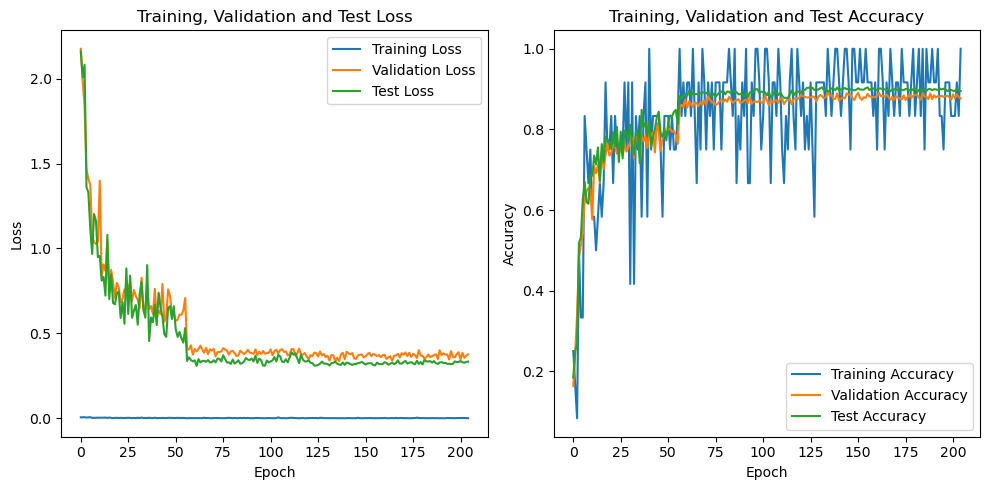

In [ ]:
view = LogViewer(logs)
view.draw()

In [ ]:
view.print_all()

1 epoch: train_loss=0.0056, train_acc=0.2500, test_loss=2.1601, test_acc=0.1842, valid_loss=2.1756, valid_acc=0.1632, lr=0.1000
2 epoch: train_loss=0.0055, train_acc=0.1667, test_loss=2.0074, test_acc=0.2489, valid_loss=1.9896, valid_acc=0.2424, lr=0.1000
3 epoch: train_loss=0.0064, train_acc=0.0833, test_loss=2.0821, test_acc=0.2691, valid_loss=1.8391, valid_acc=0.3384, lr=0.1000
4 epoch: train_loss=0.0040, train_acc=0.5000, test_loss=1.3600, test_acc=0.5181, valid_loss=1.4690, valid_acc=0.4832, lr=0.1000
5 epoch: train_loss=0.0051, train_acc=0.3333, test_loss=1.3300, test_acc=0.5317, valid_loss=1.4080, valid_acc=0.5128, lr=0.1000
6 epoch: train_loss=0.0062, train_acc=0.3333, test_loss=1.1169, test_acc=0.6263, valid_loss=1.3762, valid_acc=0.5396, lr=0.1000
7 epoch: train_loss=0.0025, train_acc=0.8333, test_loss=0.9675, test_acc=0.6697, valid_loss=1.0775, valid_acc=0.6292, lr=0.1000
8 epoch: train_loss=0.0022, train_acc=0.7500, test_loss=1.2025, test_acc=0.6191, valid_loss=1.0377, vali

In [ ]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))